In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.dates as mdates
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from itertools import product
from time import sleep
from tqdm import tqdm
import chocopearl as ch
import os
from datetime import datetime, timedelta
import seaborn as sns

### Load multiple pickles

In [6]:
directory = 'C:\\Users\\cg_h2\\Documents\\JRO\\cosmic_rays\\jun2023\\'
file_paths=ch.list_files(directory)[1]

In [7]:
crs = []
i=1
for file_path in file_paths:
    with open(file_path, 'rb') as f:
        print(f'processing {os.path.basename(file_path)}')
        not_end=True
        while not_end:
            try:
                obj = pickle.load(f)
                crs.append(obj)
                #clear_output(wait=True)
                #print(f"CosmicRay: {i}")
                i+=1
            except EOFError as e:
                not_end=False
print(f'Total: {i} Cosmic Rays')

processing trails_jun2023_1_CR.pickle
processing trails_jun2023_2_CR.pickle
processing trails_jun2023_3_CR.pickle
processing trails_jun2023_4_CR.pickle
processing trails_jun2023_5_CR.pickle
processing trails_jun2023_6_CR.pickle
processing trails_jun2023_7_CR.pickle
processing trails_jun2023_8_CR.pickle
processing trails_jun2023_9_CR.pickle
Total: 16014 Cosmic Rays


### Load single pickle

In [2]:
pickle_path =  '/home/pc-igp-173/Documentos/DATA/cosmic_rays/trails_jun2023_1_CR.pickle'

crs = []
with open( pickle_path, 'rb') as f:
    i=0
    while True:
        try:
            crs.append(pickle.load(f))
            i+=1

        except EOFError as e:
            print(e)
            break

print(f"Events: {i}")

Ran out of input
Events: 171


## Explore a single event

In [4]:
cr=crs[1]

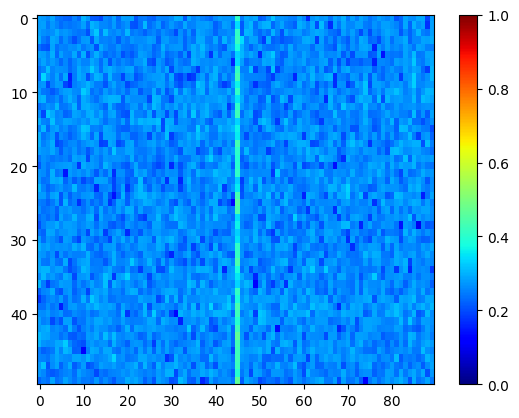

In [4]:
fig, ax = plt.subplots()
cax = ax.imshow(cr['Norm_Matrix'], cmap='jet', vmin=0, vmax=1, aspect='auto')
fig.colorbar(cax)
plt.show(fig)

In [6]:
voltages_ls=[]
power=0
Range_start_ID=cr['Range_start_ID']
Range_end_ID=cr['Range_end_ID']
for v in cr['Volt_profile']:
    voltages_ch=v[Range_start_ID:Range_end_ID+1]
    #power_ch=(voltages_ch*np.conj(voltages_ch)).real
    #power+=power_ch
    #print(v[Range_start_ID:Range_end_ID+1])
    voltages_ls.append(voltages_ch)
ranges=np.linspace(cr['Range_start'],cr['Range_end'],Range_end_ID-Range_start_ID+1)

In [7]:
cross_correlations_01 = np.angle(voltages_ls[0]*np.conj(voltages_ls[1]))
cross_correlations_02 = np.angle(voltages_ls[0]*np.conj(voltages_ls[2]))
cross_correlations_12 = np.angle(voltages_ls[1]*np.conj(voltages_ls[2]))

In [129]:
freq= 49.92  ## En MHz

wavelength=299.792458/freq
k=2*np.pi/wavelength

d=34.65*wavelength/np.sqrt(2)

dX_01,dY_01=-d,0
dX_02,dY_02=-d,-d
dX_12,dY_12=0,-d

deltas01= np.linspace(0,2*np.pi,100)
deltas02= np.linspace(0,2*np.pi,100) 
deltas12= np.linspace(0,2*np.pi,100)


0it [00:00, ?it/s]

delta01 = 0.0 
delta12 = 0.0
r2 = 0.9956662059597738


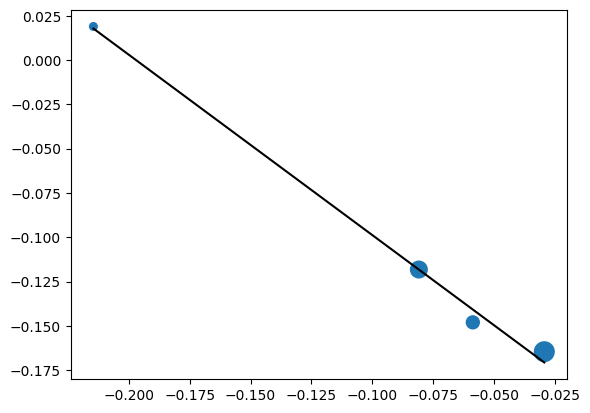

0it [00:01, ?it/s]


In [131]:
sizes = np.linspace(200,30,Range_end_ID-Range_start_ID+1)

fig, ax = plt.subplots()

for delta01,delta12 in tqdm(product(deltas01, deltas12)):
    xs=[]
    ys=[]
    for sample_id in range(Range_end_ID-Range_start_ID+1):
            
        cross_correlation_01=cross_correlations_01[sample_id]
        #cross_correlation_02=cross_correlations_02[sample_id]
        cross_correlation_12=cross_correlations_12[sample_id]
        h = ranges[0]
        
        nonh_vector = np.array([[cross_correlation_01-delta01], [cross_correlation_12-delta12]])/k
        coef_mat= np.array([[dX_01,dY_01], [dX_12,dY_12]])
        
        theta_x,theta_y=np.linalg.inv(coef_mat) @ nonh_vector
        theta_z=np.sqrt(1-theta_x**2-theta_y**2)
        
        x,y=h*theta_x/theta_z,h*theta_y/theta_z
        xs.append(x)
        ys.append(y)
        
    xs = np.asarray(xs).reshape(-1, 1)
    ys = np.asarray(ys)
    
    model = LinearRegression().fit(xs, ys)
    r2 = model.score(xs, ys)  
    
    if r2>0.95:
        print(f'delta01 = {delta01} \ndelta12 = {delta12}\nr2 = {r2}')
        x_line = np.linspace(np.min(xs), np.max(xs), 100).reshape(-1, 1)
        y_line = model.predict(x_line)
        plt.plot(x_line, y_line, color='black')
        plt.scatter(xs.flatten(),ys,s=sizes)
        plt.show()
        sleep(0.5)
        plt.pause(1)
        break



## Explore the statistics of multiple events

In [9]:
timezone_shift= -5*3600 

In [10]:
times_ls=[]
directions_ls=[]
for cr in tqdm(crs):
    freq= 49.92  ## En MHz
    
    wavelength=299.792458/freq
    k=2*np.pi/wavelength
    
    d=34.65*wavelength/np.sqrt(2)
    
    dX_01,dY_01=-d,0
    dX_02,dY_02=-d,-d
    dX_12,dY_12=0,-d
    
    delta01= 0
    delta02= 0 
    delta12= 0
    
    voltages_ls=[]
    power=0
    Range_start_ID=cr['Range_start_ID']
    Range_end_ID=cr['Range_end_ID']
    for v in cr['Volt_profile']:
        voltages_ch=v[Range_start_ID:Range_end_ID+1]
        voltages_ls.append(voltages_ch)
    ranges=np.linspace(cr['Range_start'],cr['Range_end'],Range_end_ID-Range_start_ID+1)
    
    cross_correlations_01 = np.angle(voltages_ls[0]*np.conj(voltages_ls[1]))
    cross_correlations_02 = np.angle(voltages_ls[0]*np.conj(voltages_ls[2]))
    cross_correlations_12 = np.angle(voltages_ls[1]*np.conj(voltages_ls[2]))
    
    sizes = np.linspace(200,30,Range_end_ID-Range_start_ID+1)
    
    xs=[]
    ys=[]
    for sample_id in range(Range_end_ID-Range_start_ID+1):
            
        cross_correlation_01=cross_correlations_01[sample_id]
        #cross_correlation_02=cross_correlations_02[sample_id]
        cross_correlation_12=cross_correlations_12[sample_id]
        h = ranges[0]
        
        nonh_vector = np.array([[cross_correlation_01-delta01], [cross_correlation_12-delta12]])/k
        coef_mat= np.array([[dX_01,dY_01], [dX_12,dY_12]])
        
        theta_x,theta_y=np.linalg.inv(coef_mat) @ nonh_vector
        theta_z=np.sqrt(1-theta_x**2-theta_y**2)
        
        x,y=h*theta_x/theta_z,h*theta_y/theta_z
        xs.append(x)
        ys.append(y)
        
    xs = np.asarray(xs).reshape(-1, 1)
    ys = np.asarray(ys)
    
    model = LinearRegression().fit(xs, ys)
    r2 = model.score(xs, ys)  
    
    if r2>0.8:
        m = model.coef_[0]
        theta_deg = np.degrees(np.arctan(m))
        directions_ls.append(theta_deg)
        times_ls.append(datetime.utcfromtimestamp(cr['timestamp']) + timedelta(seconds=timezone_shift))
        



100%|██████████████████████████████████████████████████████████████████████████| 16013/16013 [01:11<00:00, 225.08it/s]


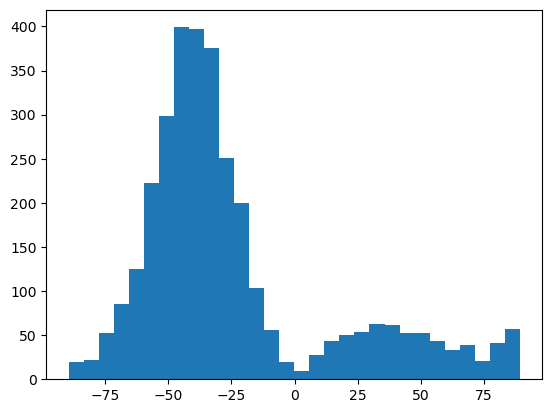

In [11]:
plt.hist(np.asarray(directions_ls).flatten(),bins=30)
plt.savefig("histograma_chunk3.png")  # Guarda como imagen PNG
plt.show()

La clase mayoritaria es el intervalo [-47.71, -41.76] con 399 elementos.


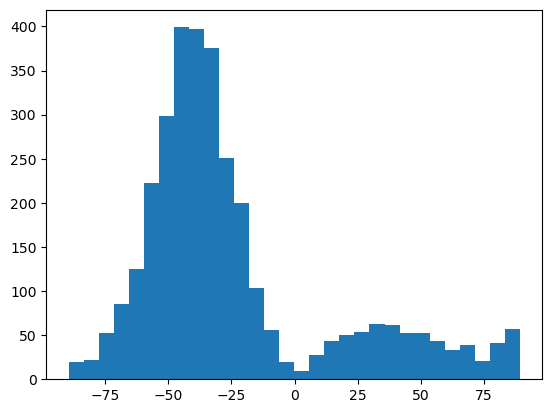

In [14]:
data = np.asarray(directions_ls).flatten()

# Graficar histograma y capturar valores
counts, bin_edges, _ = plt.hist(data, bins=30)

# Encontrar índice del bin con más elementos
max_index = np.argmax(counts)

# Obtener los límites del bin más poblado
bin_start = bin_edges[max_index]
bin_end = bin_edges[max_index + 1]

print(f"La clase mayoritaria es el intervalo [{bin_start:.2f}, {bin_end:.2f}] con {int(counts[max_index])} elementos.")

plt.show()

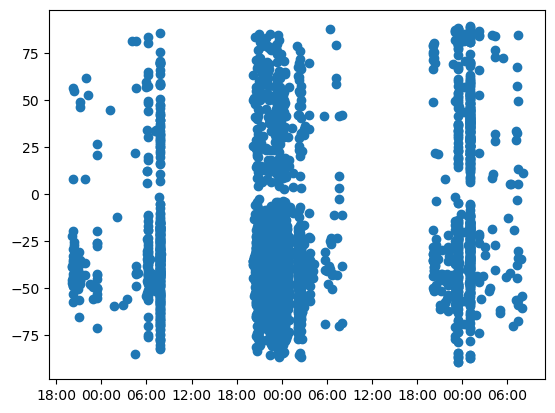

In [20]:
plt.scatter(times_ls,directions_ls)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

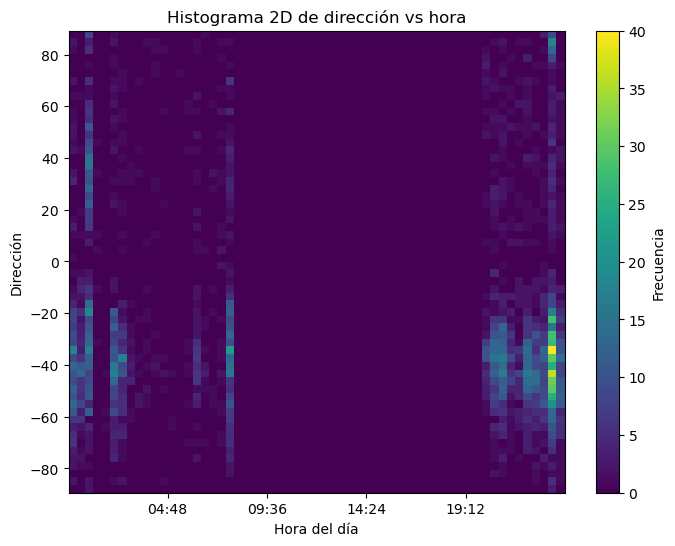

In [34]:
times_fixed_date = [datetime(2000, 1, 1, t.hour, t.minute, t.second) for t in times_ls]

# Convertir a números tipo float (días desde el 0001-01-01)
times_float = mdates.date2num(times_fixed_date)

# Graficar histograma 2D
plt.figure(figsize=(8, 6))
plt.hist2d(times_float, np.asarray(directions_ls).flatten(), bins=60, cmap='viridis')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Mostrar solo la hora
plt.colorbar(label='Frecuencia')
plt.xlabel("Hora del día")
plt.ylabel("Dirección")
plt.title("Histograma 2D de dirección vs hora")
plt.show()